# Toegepaste Machine Learning

## Practical Assignment 3

### Important Notes:
1. Submit through **Canvas** in electronic form before 11:59pm on Tuesday, May 31, 2022
2. No late homework will be accepted.
3. This is a group-of-two assignment
4. The submitted file should be in ipynb format
5. The assignment is worth it 10 points
6. **Please make sure you are in a group on canvas!**
7. Question can be asked on the discussion tab on canvas.
8. The indication **optional** means that the question is optional; you won't lose any points if you do not do that part of the assignment, nor will you gain if you do it.

### Software:
We will be using Python programming language throughout this course. Further we will be using:
+ IPython Notebooks (as an environment)
+ Numpy
+ Pandas
+ Scikit-learn


### Background:

This practical assignment will be covering clustering and working with text. 

For the assignment, please download the dataset on [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing), or simply execute the command below. 

The folder contains a number of files, of which you will be using two: plot_summaries.txt and movie.metadata.tsv. Both are tab separated files. The former, i.e. plot_summaries.txt, contains the plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary. The latter file, i.e. movie.metadata.tsv contains metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Freebase is a knowledge base (similar to a database) that contains information about different Entities (including movies). The file is tab-separated with the following columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

The goal of this assignment will be to cluster movies.

**Important Note**: This third assignment is not as instructive as the first assignment. The first assignment guided you step-by-step through all the preprocessing, training-validation-testing setup, etc. This assignment does not do so, but it leaves it up to you to decide how to use the data and design your experiments.

In [287]:
! mkdir MovieSummaries

! gdown "https://drive.google.com/uc?id=1tyun9bJq63hu9A9p11B75HjMQTCG5JpP" -O ./MovieSummaries/movie.metadata.tsv
! gdown "https://drive.google.com/uc?id=1Aeo9WwaKX39Z2zV374zLXW-ndlzcWYDn" -O ./MovieSummaries/moviesrep.csv
! gdown "https://drive.google.com/uc?id=1AnELzvfDWc6NAyV55lfrcVpAoIWzZAAl" -O ./MovieSummaries/plot_summaries.txt
! gdown "https://drive.google.com/uc?id=1CxsqcbtYzAR8S3zLSsstgC6QQa1mUPqd" -O ./MovieSummaries/README.txt

mkdir: MovieSummaries: File exists
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown


### Part 1: Import the data

We import both files and performing a join (merging the two files) using the Wikipedia ID (WID) to match the movies that appear in summaries to those that appear in the metadata. If a movie does not appear in either file, it is not included in the final list.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import metrics

In [1]:

metadata = pd.read_csv('movie.metadata.tsv',sep="\t", header = None,
                        names=['WID', 'FID', 'Name', 'Release', 'Revenue', 
                               'Runtime', 'Languages', 'Countries', 'Genres'])
summaries = pd.read_csv('plot_summaries.txt',sep="\t", header = None,
                         names=['WID', 'Text'])
films = pd.merge(metadata, summaries, on='WID')

A movie may have more than one genre. We extract the first genre that characterizes the movie. Some movies may not have any corresponing genres.

In [2]:
import ast

genres = []
for film in films.values:
    exist = False
    g = ast.literal_eval(film[8])
    # Get the first genre for this movie
    for key in g:
        exist = True
        genres.append(g[key])
        break
    # If there is no genre for this movie
    if exist is False:
        genres.append('')

Consider only movies in four genres: 'Drama', 'Comedy', 'Science Fiction', 'Action'. Then sort them by Revenue they had in the cinemas, and get the top 150 most popular ones.

In [3]:
# Merge the films with the genre into a single Dataframe
genres = pd.Series(genres, name='Genre')
films_genre = pd.concat([films, genres], axis=1)

# Get only movies about the four following genres
films_genre_ind = films_genre.set_index('Genre')
movie_genres = ['Drama', 'Comedy', 'Science Fiction', 'Action']
genre150 = pd.DataFrame()
for mg in movie_genres:
    genre150 = genre150.append(films_genre_ind.loc[mg])

# Get the top-150 of those
top150 = (genre150.sort_values(by='Revenue',ascending=False)[0:150]).reset_index()[['Name','Text','Genre']]


What you are left with are 150 movies.

In [4]:
# Show the dataframe of the top150 dataset you will be working on.
top150

,Name,Text,Genre
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction
...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action


In [5]:
# Look at the distribution of your movies in the dataset
print(top150['Genre'].value_counts())

Science Fiction    76
Drama              47
Comedy             18
Action              9
Name: Genre, dtype: int64


### Part 2: Turn movies into BoW representation (Lecture 7) (5pts)

Turn each movie plot summary (i.e. the 'Text' column in the top150 dataframe) into:

* **Bag-of-Words**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
warnings.simplefilter("ignore")

In [7]:
vectorizer_bow= CountVectorizer(stop_words='english')
X = vectorizer_bow.fit_transform(top150.Text)
bow = pd.DataFrame(X.toarray(),columns=vectorizer_bow.get_feature_names())
bow.head()

,000,00am,02,03,04,09,10,100,1000,10__pokemon__a_catchy_toon_crea,...,zoo,zoos,zorgon,zorgons,zubat,zuko,zuul,ángel,über,ōzaru
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **Bag-of-bigrams**

In [8]:

vectorizer_bo2g = CountVectorizer(stop_words='english',ngram_range=(2,2))
X = vectorizer_bo2g.fit_transform(top150.Text)
bo2g = pd.DataFrame(X.toarray(),columns=vectorizer_bo2g.get_feature_names())
bo2g.head()

,000 000,000 aaron,000 earlier,000 inheritance,000 irs,000 nbsp,000 organize,000 stars,000 words,000 years,...,ángel track,ángel tries,ángel wants,ángel wears,über morlock,über morlocks,ōzaru having,ōzaru return,ōzaru roshi,ōzaru seven
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **Bag-of-ngrams (for n = 1 and 2)**

In [9]:

vectorizer_bo12g = CountVectorizer(stop_words='english',ngram_range=(1,2))
X = vectorizer_bo12g.fit_transform(top150.Text)
bo12g = pd.DataFrame(X.toarray(),columns=vectorizer_bo12g.get_feature_names())
bo12g.head()

,000,000 000,000 aaron,000 earlier,000 inheritance,000 irs,000 nbsp,000 organize,000 stars,000 words,...,ángel wants,ángel wears,über,über morlock,über morlocks,ōzaru,ōzaru having,ōzaru return,ōzaru roshi,ōzaru seven
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* **TF-IDF values**

In [350]:
count_vect = CountVectorizer(stop_words='english')
tf_count = count_vect.fit_transform(top150.Text)
tf_count.shape

(150, 11094)

In [352]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tf = tfidf_transformer.fit_transform(tf_count)
tf_idf = pd.DataFrame(tf.toarray(), columns =tfidf_transformer.get_feature_names_out())
tf_idf.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11084,x11085,x11086,x11087,x11088,x11089,x11090,x11091,x11092,x11093
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.025748,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Part 3: Clustering (Lecture 6) (5pts)

Cluster the movies using the k-means algorithm.

**Important Note**: In order to allow you to work on Part 3, before Part 2, the [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing) folder also contains a comma-separated file, moviesrep.csv, that includes a representation I built for you from the movies plot summary. Each line corresponds to a vector representation (i.e. a set of features) for each movie and you can apply the clustering algorithm on this.

**k-means**

+ Choose the number of clusters you wish to find in the data (n_clusters)
+ Take Bag-of-words and TF-IDF representations from Part 2
+ Run a k-means algorithm
+ Evaluate the quality of the algorithm using inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score
    + some of these metrics require the use of ground truth
    + use the genre of each movie as ground truth, i.e. the perfect clustering would be the one that clusters movies based on their genre

In [12]:
### Converting Genre into Ground truth i.e. Converting Categorical data in to numeric
Genre_labels = pd.factorize(top150.Genre)[0]
Genre_labels

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 3, 0,
       0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 3, 1, 3, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1,
       0, 1, 0, 0, 2, 2, 0, 1, 3, 0, 0, 2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 2,
       0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1])

### As there are 4 different Genres of movies, i am going to find 4 clusters in the dataset.

- Bag of words (bow)

In [17]:
k_means_bow = KMeans(n_clusters=4)
k_means_bow= k_means_bow.fit(bow)
print('Inertia:',k_means_bow.inertia_)
print('silhouette_score:',metrics.silhouette_score(bow, k_means_bow.labels_))
print('adjusted_mutual_info_score:',metrics.adjusted_mutual_info_score(Genre_labels,k_means_bow.labels_))
print('adjusted_rand_score:',metrics.adjusted_rand_score(Genre_labels,k_means_bow.labels_))

Inertia: 225029.18333333277
silhouette_score: 0.03136780200379602
adjusted_mutual_info_score: 0.04023452936389939
adjusted_rand_score: -0.03349998352341243


- tf-idf

In [382]:
k_means_tfidf = KMeans(n_clusters=4)
k_means_tfidf= k_means_tfidf.fit(tf_idf)
print('Inertia:',k_means_tfidf.inertia_)
print('silhouette_score:',metrics.silhouette_score(tf_idf, k_means_tfidf.labels_))
print('adjusted_mutual_info_score:',metrics.adjusted_mutual_info_score(Genre_labels,k_means_tfidf.labels_))
print('adjusted_rand_score:',metrics.adjusted_rand_score(Genre_labels,k_means_tfidf.labels_))

Inertia: 142.68014896855925
silhouette_score: 0.004889045079736778
adjusted_mutual_info_score: 0.04839019714724223
adjusted_rand_score: 0.0915539064460909


**Number of cluster**

* Change the value of n\_clusters and plot inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score as a function of n_clusters
* Explain what you observe in the plots.
* Do the same for each text representation from Part 2.
* Explain the differences across different representations if there are any

### Bag of Words

Text(0.5, 1.0, 'Elbow Method For Optimal k')

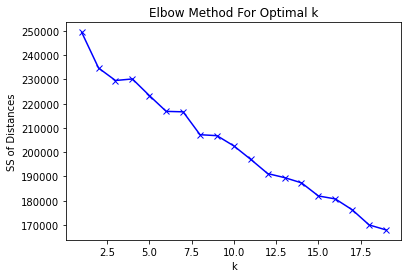

In [45]:
# Inertia, adjusted_mutual_info_score,adjusted_rand_score,silhouette_score
#Finding Best k using Elbow Method 
SS_distances= []
SS_distances2= []
amis= []
ars= []
I = range(1,20)
for i in I:
       k_means = KMeans(n_clusters=i)
       k_means= k_means.fit(bow)
       SS_distances.append(k_means.inertia_)
       score_KM2= metrics.adjusted_mutual_info_score(Genre_labels,k_means.labels_)
       amis.append(score_KM2)
       score_KM3= metrics.adjusted_rand_score(Genre_labels,k_means.labels_)
       ars.append(score_KM3)
       if i >1:
              score_H= metrics.silhouette_score(bow, k_means.labels_)
              SS_distances2.append(score_H)
       else:
              SS_distances2.append(0)

centers = k_means.cluster_centers_

# plotting SSE distances (for each point to the nearest Center) versus number of k 
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SS of Distances')
plt.title('Elbow Method For Optimal k')

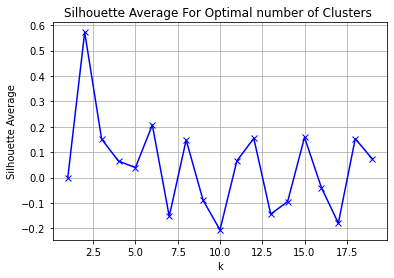

In [46]:
# plotting Silhouette for different clusters
plt.plot(I, SS_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Average For Optimal number of Clusters ')    
plt.grid()

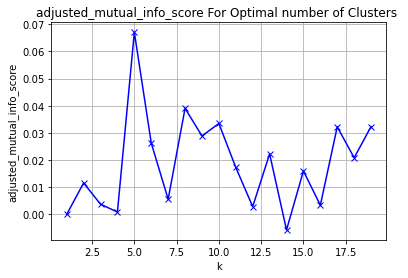

In [47]:
# plotting adjusted_mutual_info_score for different clusters
plt.plot(I, amis, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_mutual_info_score')
plt.title('adjusted_mutual_info_score For Optimal number of Clusters ')    
plt.grid()

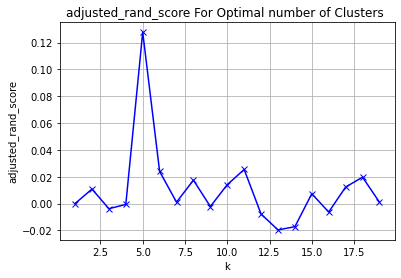

In [48]:
# plotting adjusted_rand_score for different clusters
plt.plot(I, ars, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')
plt.title('adjusted_rand_score For Optimal number of Clusters ')    
plt.grid()

Optimal number of clusters based on elbow method and silhouette_score is 2.

### Bag of bigrams

Text(0.5, 1.0, 'Elbow Method For Optimal k')

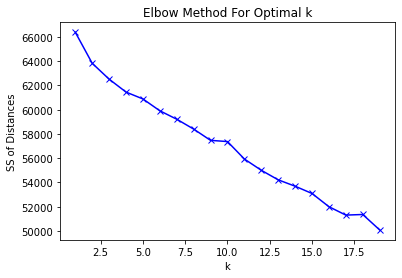

In [54]:
# Inertia, adjusted_mutual_info_score,adjusted_rand_score,silhouette_score
#Finding Best k using Elbow Method 
SS_distances= []
SS_distances2= []
amis= []
ars= []
I = range(1,20)
for i in I:
       k_means = KMeans(n_clusters=i)
       k_means= k_means.fit(bo2g)
       SS_distances.append(k_means.inertia_)
       score_KM2= metrics.adjusted_mutual_info_score(Genre_labels,k_means.labels_)
       amis.append(score_KM2)
       score_KM3= metrics.adjusted_rand_score(Genre_labels,k_means.labels_)
       ars.append(score_KM3)
       if i >1:
              score_H= metrics.silhouette_score(bo2g, k_means.labels_)
              SS_distances2.append(score_H)
       else:
              SS_distances2.append(0) 

centers = k_means.cluster_centers_

# plotting SSE distances (for each point to the nearest Center) versus number of k 
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SS of Distances')
plt.title('Elbow Method For Optimal k')

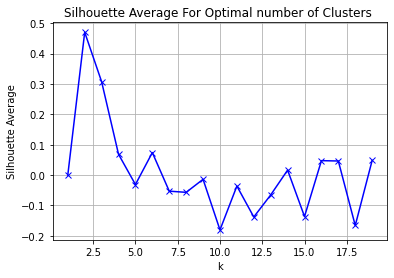

In [55]:
# plotting Silhouette for different clusters
plt.plot(I, SS_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Average For Optimal number of Clusters ')    
plt.grid()

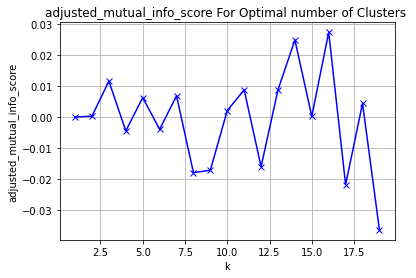

In [56]:
# plotting adjusted_mutual_info_score for different clusters
plt.plot(I, amis, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_mutual_info_score')
plt.title('adjusted_mutual_info_score For Optimal number of Clusters ')    
plt.grid()

In [ ]:
# plotting adjusted_rand_score for different clusters
plt.plot(I, ars,'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')
plt.title('adjusted_rand_score For Optimal number of Clusters ')    
plt.grid()

Optimal number of clusters based on elbow method and silhouette_score is 2.

### Bag of 1-2 grams

Text(0.5, 1.0, 'Elbow Method For Optimal k')

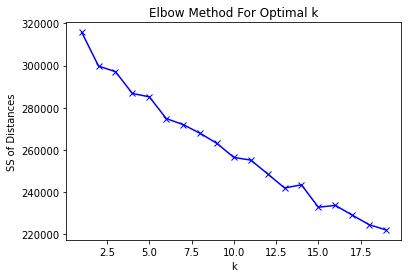

In [58]:
# Inertia, adjusted_mutual_info_score,adjusted_rand_score,silhouette_score
#Finding Best k using Elbow Method 
SS_distances= []
SS_distances2= []
amis= []
ars= []
I = range(1,20)
for i in I:
       k_means = KMeans(n_clusters=i)
       k_means= k_means.fit(bo12g)
       SS_distances.append(k_means.inertia_)
       score_KM2= metrics.adjusted_mutual_info_score(Genre_labels,k_means.labels_)
       amis.append(score_KM2)
       score_KM3= metrics.adjusted_rand_score(Genre_labels,k_means.labels_)
       ars.append(score_KM3)
       if i >1:
              score_H= metrics.silhouette_score(bo12g, k_means.labels_)
              SS_distances2.append(score_H)
       else:
              SS_distances2.append(0) 

centers = k_means.cluster_centers_

# plotting SSE distances (for each point to the nearest Center) versus number of k 
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SS of Distances')
plt.title('Elbow Method For Optimal k')

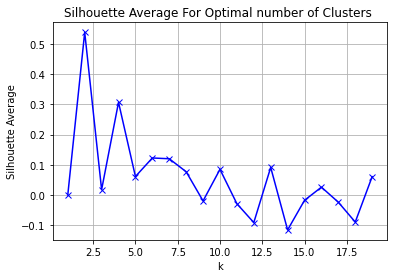

In [62]:
# plotting Silhouette for different clusters
plt.plot(I, SS_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Average For Optimal number of Clusters ')    
plt.grid()

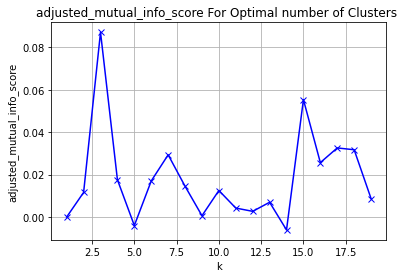

In [63]:
# plotting adjusted_mutual_info_score for different clusters
plt.plot(I, amis, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_mutual_info_score')
plt.title('adjusted_mutual_info_score For Optimal number of Clusters ')    
plt.grid()

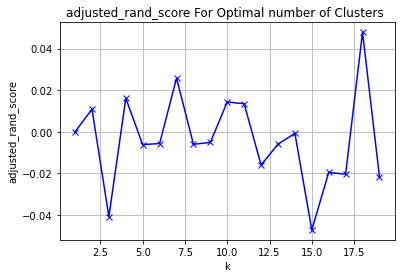

In [64]:
# plotting adjusted_rand_score for different clusters
plt.plot(I, ars, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')
plt.title('adjusted_rand_score For Optimal number of Clusters ')    
plt.grid()

Optimal number of clusters based on elbow method and silhouette_score is 2.

### tf-idf

Text(0.5, 1.0, 'Elbow Method For Optimal k')

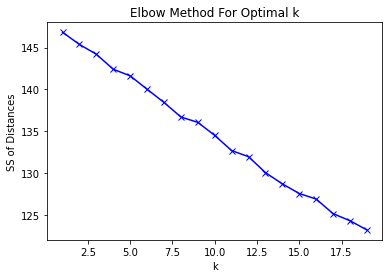

In [389]:
# Inertia, adjusted_mutual_info_score,adjusted_rand_score,silhouette_score
#Finding Best k using Elbow Method 
SS_distances= []
SS_distances2= []
amis= []
ars= []
I = range(1,20)
for i in I:
       k_means = KMeans(n_clusters=i)
       k_means= k_means.fit(tf_idf)
       SS_distances.append(k_means.inertia_)
       score_KM2= metrics.adjusted_mutual_info_score(Genre_labels,k_means.labels_)
       amis.append(score_KM2)
       score_KM3= metrics.adjusted_rand_score(Genre_labels,k_means.labels_)
       ars.append(score_KM3)
       if i >1:
              score_H= metrics.silhouette_score(tf_idf, k_means.labels_)
              SS_distances2.append(score_H)
       else:
              SS_distances2.append(0) 

centers = k_means.cluster_centers_

# plotting SSE distances (for each point to the nearest Center) versus number of k 
plt.plot(I, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SS of Distances')
plt.title('Elbow Method For Optimal k')

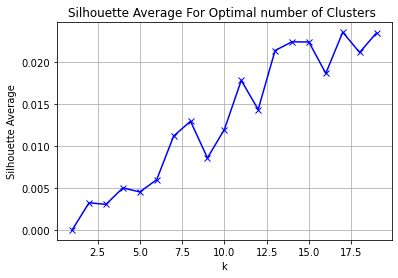

In [390]:
# plotting Silhouette for different clusters
plt.plot(I, SS_distances2, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Average For Optimal number of Clusters ')    
plt.grid()

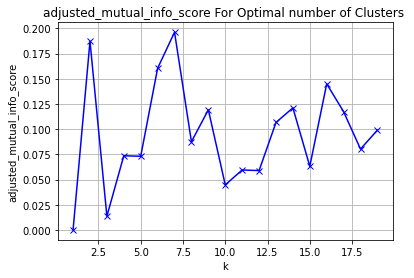

In [391]:
# plotting adjusted_mutual_info_score for different clusters
plt.plot(I, amis, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_mutual_info_score')
plt.title('adjusted_mutual_info_score For Optimal number of Clusters ')    
plt.grid()

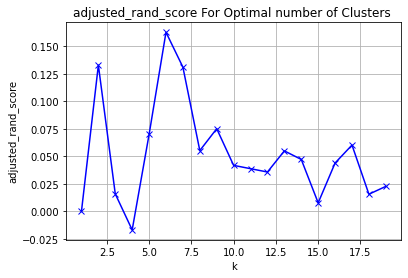

In [392]:
# plotting adjusted_rand_score for different clusters
plt.plot(I, ars, 'bx-')
plt.xlabel('k')
plt.ylabel('adjusted_rand_score')
plt.title('adjusted_rand_score For Optimal number of Clusters ')    
plt.grid()

Optimal number of clusters based on elbow method and silhouette_score is 4.

- Explain the differences across different representations if there are any.

Our analysis for All representations except for tf_idf indicates that the suitable number of clusters is 2. The intertia and silhouette_score at cluster number 2 is better than other number of clusters. For tf_idf, we get ideal number of clusters to be 4, which is equal to the number of categories of Genre.

**Demonstrate clusters**

* for each representation choose the optimal number of clusters and repeat the k-means algorithm for that number of clusters
* print the top-10 most important words within each cluster
* print the titles of the movies for each cluster
* explain what you observe and whether results make sense

- Bag of words

In [310]:
### For Bag of words optimal number of Clusters is 2
k_means_bow = KMeans(n_clusters=2,init='k-means++', max_iter=100, n_init=1)
k_means_bow= k_means_bow.fit(bow)
print('Inertia:',k_means_bow.inertia_)
#print('silhouette_score:',metrics.silhouette_score(bow, k_means_bow.labels_))
labels_df = k_means_bow.labels_

labels_df = pd.DataFrame(labels_df)
labels_df.value_counts()


Inertia: 245271.3541666665


0    144
1      6
dtype: int64

In [311]:
movies_bow = top150

In [312]:
movies_bow['Cluster'] = labels_df
movies_bow

,Name,Text,Genre,Cluster
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction,0
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama,0
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction,1
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction,1
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction,0
...,...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama,0
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama,0
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction,0
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action,0


In [313]:
print("Top words in each cluster:")
order_centroids = k_means_bow.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_bow.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    

Top words in each cluster:
Cluster 0:
 father
 tells
 new
 time
 home
 life
 later
 day
 help
 dave
Cluster 1:
 luke
 obi
 wan
 vader
 jedi
 anakin
 han
 leia
 palpatine
 death


- Movies in each Cluster
  
Cluster 1

In [314]:
movies_bow.Name[movies_bow.Cluster==0]

0                                           The Avengers
1          Harry Potter and the Deathly Hallows – Part 2
4                             E.T. the Extra-Terrestrial
6              The Twilight Saga: Breaking Dawn - Part 1
8                                         Men in Black 3
                             ...                        
145                                             Brothers
146                                      Regarding Henry
147                                         Time Bandits
148    Naruto the Movie: Snow Princess' Book of Ninja...
149                                             Disgrace
Name: Name, Length: 144, dtype: object

Cluster 2

In [315]:
movies_bow.Name[movies_bow.Cluster==1]

2          Star Wars Episode I: The Phantom Menace
3       Star Wars Episode III: Revenge of the Sith
5                 Star Wars Episode IV: A New Hope
7       Star Wars Episode II: Attack of the Clones
10    Star Wars Episode V: The Empire Strikes Back
12        Star Wars Episode VI: Return of the Jedi
Name: Name, dtype: object

### Bag of bigram

In [291]:
### For Bag of words optimal number of Clusters is 2
k_means_bo2g = KMeans(n_clusters=2,init='k-means++', max_iter=100, n_init=1)
k_means_bo2g= k_means_bo2g.fit(bo2g)
print('Inertia:',k_means_bo2g.inertia_)
#print('silhouette_score:',metrics.silhouette_score(bo2g, k_means_bo2g.labels_))
labels_df = k_means_bo2g.labels_
labels_df = pd.DataFrame(labels_df)
labels_df.value_counts()

Inertia: 65519.95205478479


0    146
1      4
dtype: int64

In [292]:
movies_bo2g = top150

In [293]:
movies_bo2g['Cluster'] = labels_df
movies_bo2g

,Name,Text,Genre,Cluster
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction,0
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama,0
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction,0
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction,1
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction,0
...,...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama,0
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama,0
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction,0
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action,0


In [294]:
print("Top words in each cluster:")
order_centroids = k_means_bo2g.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_bo2g.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    

Top words in each cluster:
Cluster 0:
 snow white
 new york
 year old
 gang du
 york city
 high school
 day day
 queen clementianna
 hyun seo
 united states
Cluster 1:
 obi wan
 death star
 r2 d2
 anakin skywalker
 lightsaber duel
 wan kenobi
 imperial forces
 3po r2
 anakin padmé
 clone army


- Movies in each Cluster
  
Cluster 1

In [295]:
movies_bo2g.Name[movies_bo2g.Cluster==0]

0                                           The Avengers
1          Harry Potter and the Deathly Hallows – Part 2
2                Star Wars Episode I: The Phantom Menace
4                             E.T. the Extra-Terrestrial
6              The Twilight Saga: Breaking Dawn - Part 1
                             ...                        
145                                             Brothers
146                                      Regarding Henry
147                                         Time Bandits
148    Naruto the Movie: Snow Princess' Book of Ninja...
149                                             Disgrace
Name: Name, Length: 146, dtype: object

Cluster 2

In [296]:
movies_bo2g.Name[movies_bo2g.Cluster==1]

3     Star Wars Episode III: Revenge of the Sith
5               Star Wars Episode IV: A New Hope
7     Star Wars Episode II: Attack of the Clones
12      Star Wars Episode VI: Return of the Jedi
Name: Name, dtype: object

- Bag of 1-2 gram

In [329]:
### For Bag of words optimal number of Clusters is 2
k_means_bo12g = KMeans(n_clusters=2,init='k-means++', max_iter=100, n_init=1)
k_means_bo12g= k_means_bo12g.fit(bo12g)
print('Inertia:',k_means_bo12g.inertia_)
#print('silhouette_score:',metrics.silhouette_score(bo12g, k_means_bo2g.labels_))
labels_df = k_means_bo12g.labels_
labels_df = pd.DataFrame(labels_df)
labels_df.value_counts()


Inertia: 310694.3888888967


0    144
1      6
dtype: int64

In [331]:
movies_bo12g = top150

In [332]:
movies_bo12g['Cluster'] = labels_df
movies_bo12g

,Name,Text,Genre,Cluster
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction,0
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama,0
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction,1
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction,1
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction,0
...,...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama,0
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama,0
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction,0
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action,0


In [333]:
print("Top words in each cluster:")
order_centroids = k_means_bo12g.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_bo12g.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    

Top words in each cluster:
Cluster 0:
 father
 tells
 new
 time
 home
 life
 later
 day
 help
 dave
Cluster 1:
 luke
 obi wan
 obi
 wan
 vader
 anakin
 jedi
 han
 leia
 palpatine


- Movies in each Cluster
  
Cluster 1

In [334]:
movies_bo12g.Name[movies_bo12g.Cluster==0]

0                                           The Avengers
1          Harry Potter and the Deathly Hallows – Part 2
4                             E.T. the Extra-Terrestrial
6              The Twilight Saga: Breaking Dawn - Part 1
8                                         Men in Black 3
                             ...                        
145                                             Brothers
146                                      Regarding Henry
147                                         Time Bandits
148    Naruto the Movie: Snow Princess' Book of Ninja...
149                                             Disgrace
Name: Name, Length: 144, dtype: object

Cluster 2

In [335]:
movies_bo12g.Name[movies_bo12g.Cluster==1]

2          Star Wars Episode I: The Phantom Menace
3       Star Wars Episode III: Revenge of the Sith
5                 Star Wars Episode IV: A New Hope
7       Star Wars Episode II: Attack of the Clones
10    Star Wars Episode V: The Empire Strikes Back
12        Star Wars Episode VI: Return of the Jedi
Name: Name, dtype: object

- TF_IDF

In [393]:
### For tf_idf optimal number of Clusters is 4
k_means_tfidf = KMeans(n_clusters=4,init='k-means++', max_iter=100, n_init=1)
k_means_tfidf= k_means_tfidf.fit(tf_idf)
print('Inertia:',k_means_tfidf.inertia_)
#print('silhouette_score:',metrics.silhouette_score(tf_idf, k_means_tfidf.labels_))
labels_df = k_means_tfidf.labels_
labels_df = pd.DataFrame(labels_df)
labels_df.value_counts()


Inertia: 143.06046453680233


3    75
1    43
2    17
0    15
dtype: int64

In [394]:
movies_tfidf = top150

In [395]:
movies_tfidf['Cluster'] = labels_df
movies_tfidf

,Name,Text,Genre,Cluster
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction,1
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama,3
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction,1
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction,1
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction,3
...,...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama,3
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama,3
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction,3
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action,0


In [396]:
print("Top words in each cluster:")
order_centroids = k_means_tfidf.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    

Top words in each cluster:
Cluster 0:
 david
 ghostbusters
 matrix
 max
 imhotep
 atlantis
 juni
 island
 vilain
 doto
Cluster 1:
 luke
 alien
 obi
 wan
 earth
 planet
 vader
 ship
 anakin
 jedi


- Movies in each Cluster
  
Cluster 1

In [397]:
movies_tfidf.Name[movies_tfidf.Cluster==0]

14                                             The Mummy
26                                          Ghostbusters
27                                     The Expendables 2
34                          A.I. Artificial Intelligence
38                                       Ghostbusters II
43                               Spy Kids 3-D: Game Over
44                             Atlantis: The Lost Empire
53                                   Swearing Allegiance
81                             Where the Wild Things Are
89                                              The Host
93                                                Cocoon
113                                        The Rocketeer
118                                             Commando
123                                      Rugrats Go Wild
148    Naruto the Movie: Snow Princess' Book of Ninja...
Name: Name, dtype: object

Cluster 2

In [398]:
movies_tfidf.Name[movies_tfidf.Cluster==1]

0                                      The Avengers
2           Star Wars Episode I: The Phantom Menace
3        Star Wars Episode III: Revenge of the Sith
5                  Star Wars Episode IV: A New Hope
6         The Twilight Saga: Breaking Dawn - Part 1
7        Star Wars Episode II: Attack of the Clones
8                                    Men in Black 3
10     Star Wars Episode V: The Empire Strikes Back
12         Star Wars Episode VI: Return of the Jedi
13                                  Men in Black II
18                              Monsters vs. Aliens
23                               The Last Airbender
24                                       Battleship
28                                    Lilo & Stitch
31                                The Bourne Legacy
37                                   Wild Wild West
42                    You Don't Mess with the Zohan
45                                     Total Recall
57                    Star Trek: The Motion Picture
64          

Cluster 3

In [399]:
movies_tfidf.Name[movies_tfidf.Cluster==2]

9                                          Puss in Boots
15                           Snow White and the Huntsman
16                                      Superman Returns
25                                              Superman
36     Interview with the Vampire: The Vampire Chroni...
49                                              Cocktail
52                                         Mirror Mirror
60                                                 Babel
72                                           Superman II
82                                          October Baby
83                                             G.I. Jane
87                                        Back to School
88                                          Galaxy Quest
97                                              The Grey
104                                            The Watch
106                           Madea's Witness Protection
128                                         Big Fat Liar
Name: Name, dtype: object

Cluster 4

In [400]:
movies_tfidf.Name[movies_tfidf.Cluster==3]

1      Harry Potter and the Deathly Hallows – Part 2
4                         E.T. the Extra-Terrestrial
11                                               Ted
17                                Back to the Future
19                Close Encounters of the Third Kind
                           ...                      
144                                        Soul Food
145                                         Brothers
146                                  Regarding Henry
147                                     Time Bandits
149                                         Disgrace
Name: Name, Length: 75, dtype: object

### Explanation
The clusters formed by tf-idf are far better than other other text representations. The quality measures scores are not up to the mark as the number of features is really huge (10000+ atleast). However, the groups formed by tf_idf makes more sense than other.